# Cluster Analysis: Lexico-grammatical style (S. 5.2)

In [1]:
from mqdq import utils, babble, ngrams

import numpy as np
import pandas as pd
import scipy as sp

import glob
import umap

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

/Users/ben/venv/py39/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ben/venv/py39/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ben/venv/py39/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

In [2]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.basicConfig(level="INFO")

In [3]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs("corpus/OV-epis.xml", name="Ep.")
for b in ep:
    b.author = "Ovid"
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob("corpus/OV-tri*.xml")), name="Tr.")
for b in tr:
    b.author = "Ovid"
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob("corpus/OV-amo*.xml")), name="Am.")
for b in am:
    b.author = "Ovid"
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob("corpus/TIB-ele*.xml")), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = "Tibullus"
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob("corpus/PROP-ele*.xml")), name="Prop.")
for b in prop:
    b.author = "Propertius"
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs("corpus/CATVLL-carm.xml", name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = "Catullus"
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob("corpus/OV-pon*.xml")), name="Pont.")
for b in pon:
    b.author = "Ovid"
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)

In [4]:
nux = babble.Babbler.from_file("./corpus/OV-nux.xml", name="Nux")
nux.author = "ps-Ovid"
collection.append(nux)
ibis = babble.Babbler.from_file("./corpus/OV-ibis.xml", name="Ibis")
ibis.author = "ps-Ovid"
medi = babble.Babbler.from_file("./corpus/OV-medi.xml", name="Medicamina")
medi.author = "ps-Ovid"
collection.append(medi)
cons = babble.Babbler.from_file("./corpus/OV-cons.xml", name="consolatio")
cons.author = "ps-Ovid"

In [5]:
ll = cons.raw_source
sz = 158
cons_chunks = [ll[i : i + sz] for i in range(0, len(ll), sz)]
cons_ary = []
for i in range(len(cons_chunks)):
    b = babble.Babbler(cons_chunks[i], name=f"Consolatio {i+1}")
    b.author = "ps-Ovid"
    cons_ary.append(b)
collection.extend(cons_ary)
[f"{x.name} - {len(x)}" for x in cons_ary]

['Consolatio 1 - 158', 'Consolatio 2 - 158', 'Consolatio 3 - 158']

In [6]:
ll = ibis.raw_source
sz = 200
# I'm going to declare the "intro" to end at line 66, and the actual 'curse' to
# begin at 67 'di maris et terrae...'. I break them up this way because the
# style is noticably different in the 'intro', whereas the bulk of the rest
# follows standard tropes for invocations (huge amounts of polysyndeton for
# example)
ibis_chunks = [ll[i : i + sz] for i in range(64, len(ll), sz)]
ibis_chunks = [ll[:64]] + ibis_chunks
ibis_ary = []
for i in range(len(ibis_chunks)):
    b = babble.Babbler(ibis_chunks[i], name=f"Ibis {i+1}")
    b.author = "ps-Ovid"
    ibis_ary.append(b)
collection.extend(ibis_ary)
[f"{x.name} - {len(x)}" for x in ibis_ary]

['Ibis 1 - 64', 'Ibis 2 - 200', 'Ibis 3 - 200', 'Ibis 4 - 178']

In [7]:
non_elegy = []

aen_single_bab = babble.Babbler.from_file(
    "./corpus/VERG-aene.xml", name="Aeneid", author="Vergil"
)
non_elegy.append(aen_single_bab)

geo_single_bab = babble.Babbler.from_file(
    "./corpus/VERG-geor.xml", name="Georgics", author="Vergil"
)
non_elegy.append(geo_single_bab)

sat_single_bab = babble.Babbler.from_file(
    "./corpus/IVV-satu.xml", name="Juv. Sat.", author="Juvenal"
)
non_elegy.append(sat_single_bab)

puni_single_bab = babble.Babbler.from_file(
    "./corpus/SIL-puni.xml", name="Punica", author="Silius"
)
non_elegy.append(puni_single_bab)

theb_single_bab = babble.Babbler.from_file(
    "./corpus/STAT-theb.xml", name="Thebaid", author="Statius"
)
non_elegy.append(theb_single_bab)

phars_single_bab = babble.Babbler.from_file(
    "./corpus/LVCAN-phar.xml", name="Pharsalia", author="Lucan"
)
non_elegy.append(phars_single_bab)

arg_single_bab = babble.Babbler.from_file(
    "./corpus/VAL_FL-argo.xml", name="Argonautica", author="V.Flaccus"
)
non_elegy.append(arg_single_bab)

rena_single_bab = babble.Babbler.from_file(
    "./corpus/LVCR-rena.xml", name="DRN", author="Lucretius"
)
non_elegy.append(rena_single_bab)

horsat_single_bab = babble.Babbler.from_file(
    *sorted(glob.glob("./corpus/HOR-sat*.xml")), name="Hor. Sat.", author="Horace"
)
non_elegy.append(horsat_single_bab)

In [8]:
def subsample(ary, mu=80, sd=20, n=100, min_len=20):
    lengths = [x for x in np.random.normal(mu, sd, n * 2).astype(int) if x > min_len]
    samps = []
    for i in range(n):
        l = lengths[i]
        b = ary[i % len(ary)]
        start = np.random.randint(len(b) - l)
        samps.append(
            babble.Babbler(
                b.raw_source[start : start + l], name=f"{i}-{b.name}", author=b.author
            )
        )
    return samps

In [9]:
non_elegy_sample = subsample(non_elegy, n=200)

In [10]:
%load_ext rpy2.ipython

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /Library/Frameworks/R.framework/Resources
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


# Preprocessing - Text Conversion

For this analysis the vectorisation is a little different
to the poetic analysis. The first step is to convert each
poem into a string and perform phonetic conversion. Named
Entity Removal is not done. In the case of the Heroides,
each poem (or each pair, in the Double letters) uses a different
set of characters, so there is little risk that poems might be artificially
clustered with the Heroides simply because of Named Entities.

In [11]:
# the +_just stringify+ method is from my MQDQParser library.


def vectorise_babs(babs):
    vecs = []
    for b in babs:
        v = pd.DataFrame()
        v["Chunk"] = ["".join(ngrams._just_stringify(b.raw_source, type="phon"))]
        v.insert(0, "Poem", b.name)
        v.insert(0, "Work", b.name.split(" ")[0])
        if hasattr(b, "author"):
            v.insert(0, "Author", b.author)
        vecs.append(v)
    df = pd.concat(vecs)
    df.reset_index(drop=True, inplace=True)
    return df

In [12]:
# Now everything is nicely lowercased with punctuation
# stripped, but retaining linebreaks. Phonetic conversion
# has also been done.

vecs = vectorise_babs(collection)
vecs.insert(3, "LEN", [len(b) for b in collection])
vecs

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...


In [13]:
non_elegy_vecs = vectorise_babs(non_elegy_sample)
non_elegy_vecs.insert(3, "LEN", [len(b) for b in non_elegy_sample])
non_elegy_vecs

,Author,Work,Poem,LEN,Chunk
0,Vergil,0-Aeneid,0-Aeneid,46,detrudunt nawis skopulo lewat ipse tridenti\ne...
1,Vergil,1-Georgics,1-Georgics,56,flumi_namem silwas_kwinglorius o ubi kampi\nsp...
2,Juvenal,2-Juv.,2-Juv. Sat.,82,judikio kwid enim salwis infamia nummis\neksul...
3,Silius,3-Punica,3-Punica,38,dum remeat wiktor lakrimis perfudit et amens\n...
4,Statius,4-Thebaid,4-Thebaid,117,blandus adhuk okuliskwe tremens et murmure gor...
...,...,...,...,...,...
195,V.Flaccus,195-Argonautica,195-Argonautica,81,per klipei kedentis opus kratemkwe trilikem\nk...
196,Lucretius,196-DRN,196-DRN,86,turbabant saewi nullo diskrimine turmas\nterri...
197,Horace,197-Hor.,197-Hor. Sat.,90,ak pater ut gnati sik nos debemus amiki\nsi kw...
198,Vergil,198-Aeneid,198-Aeneid,111,te penes in _tomnis domus inklinata rekumbit\n...


# Cluster Analysis, using LSA data

Now we filter poems shorter than 20 lines (only 8 works) and then do LSA. This involves:
1. Performing TF-IDF vectorisation, using 2-, 3-, and 4-grams
2. Reducing this high-dimensional data to 50 dimensions using SVD
3. Normalizing the resulting vectors

The process is fairly standard. 50 dimensions is somewhat arbitrary, but is the 'usual' number.

In [14]:
corpus = vecs[vecs.LEN >= 20]

In [15]:
vectorizer = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True, use_idf=False, norm="l2", analyzer="char", ngram_range=(2, 4)
    ),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    StandardScaler(),
    TruncatedSVD(50, random_state=42),
    Normalizer(),
)
lsa_data = vectorizer.fit_transform(corpus.Chunk)

# Projection Methods

These are Figs 4(b) and 4(c). Both UMAP and t-SNE attempt to produce a 2D figure in which the local manifold properties of the high dimensional space is preserved. In other words, points that are _locally_ 'near' in the original feature space (43 dimensions) should end up locally 'near' in the projection, however the overall topology is somewhat arbitrary; points should cluster correctly, but the distribution of the clusters across the 2D figure may not reflect the true inter-cluster distances. UMAP more or less 'just works' while t-SNE has a `perplexity` parameter which affects the tightness of the clusters (sometimes it is described as broadly analagous to the _k_ in _k_ nearest neighbours.

Neither of these projections produce a result where distances are easy to understand statistically, and so they are qualitative methods (no _P_-values here!).

In [16]:
# Project the TF-IDF points down to 2D

# Most of this is fairly standard, but the set_op_mix_ratio parameter is a little
# unusual. This is the UMAP author's recommendation for outlier detection:
# https://umap-learn.readthedocs.io/en/latest/outliers.html

umap_results = corpus.copy()

umapper = umap.UMAP(
    n_neighbors=15,
    # project to 2 dimensions
    n_components=2,
    min_dist=0.4,
    set_op_mix_ratio=0.25,
    metric="euclidean",
    # UMAP figures change with every run if not seeded
    random_state=42,
)

u = umapper.fit_transform(lsa_data)
umap_results["X"], umap_results["Y"] = u[:, 0], u[:, 1]

# Now we have an X-Y coordinate applied to every chunk

umap_results

,Author,Work,Poem,LEN,Chunk,X,Y
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...,8.400394,2.146967
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...,8.071579,2.994561
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...,8.163002,1.628859
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...,8.326596,4.980209
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...,8.532336,1.538429
...,...,...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...,7.611369,4.171093
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...,7.763978,6.247133
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...,8.565356,3.219527
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...,8.422803,3.407756


Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



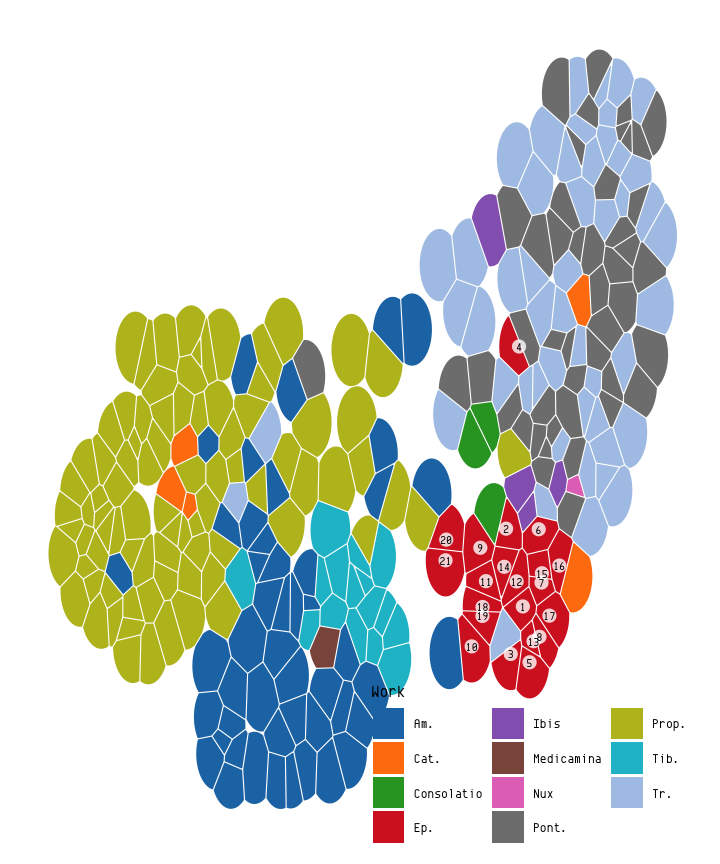

In [17]:
%%R -i umap_results -h 6 -w 5 -u in -r 144

library(ggforce)
library(ggsci)
library(dplyr)
library(stringr)
library(paletteer)


pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", 'grey50', "#A65628")

ep <- umap_results %>% 
    filter(Work=='Ep.') %>%
    mutate(Num = str_extract(Poem, "[0-9]+"))
    
ggplot(data=umap_results,aes(x=X, y=Y)) +
# Voronoi tesselation for everything
geom_voronoi_tile(
    aes(fill = Work, group = -1L, ),
    max.radius = 0.4,
    expand = unit(-0.1, 'mm'), 
    radius = unit(0.1, 'mm')
) +
# Add numbered points just for the Heroides
geom_point(data=ep,color='white',alpha=0.8, size=3,shape=16) +
geom_text(data=ep,aes(label=Num),family='Envy Code R',size=2) +

scale_fill_paletteer_d('ggsci::category20_d3') +
guides(fill = guide_legend(ncol=3,override.aes=list(size=0.5))) +

theme_minimal() +

theme(
    panel.border = element_blank(),
    legend.position=c(0.74,0.10),
    axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    axis.title.y=element_blank(),
    axis.text.y=element_blank(),
    axis.ticks.y=element_blank(),
    text=element_text(size=8, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank()
)

# fn <- "../paper/figures/ele_ngrams_umap.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)


# Bootstrap Consensus Tree

For the idea, see Maciej Eder, (2017) Visualization in stylometry: Cluster analysis using networks, Digital Scholarship in the Humanities, 32 (1), Pages 50–64, https://doi.org/10.1093/llc/fqv061, and see also the implementation in R Stylo. The previous visualisations project from high dimensional _position_ (from the LSA data in 50 dimensions) to 2D. This method constructs many kNN trees from feature subsets, with each tree giving the closest three nodes artificial weights (3, 2, 1). The trees are then aggregated, with the idea that neighbours that are truly related will be close in many of the subset feature universes. The final layout is artificial. Users of `stylo` tend to use Gephi and ForceAtlas2, but in this case I use Fruchterman-Reingold (more or less the same idea) which can be easily done in R with `ggraph`. Once the consensus tree is trimmed, it could be laid out with many different algorithms, and the results are broadly similar (the point positions may change slightly but the overall topological implications don't vary). The advantage of this BCT method is that is shows the strength of the relationships as well as the determined positions.


In [18]:
df = pd.DataFrame(lsa_data)
X, y = df, list(corpus.Poem)

In [19]:
dfs = []
rng = np.random.RandomState(seed=42)
for _ in range(500):
    # Sample 15 random features (columns)
    this_X = X.sample(15, axis=1, random_state=rng)

    # Calculate kNN in that space
    cl = KNeighborsClassifier(n_neighbors=3, metric="cosine")
    cl.fit(this_X, y)
    dists, indices = cl.kneighbors(n_neighbors=3)

    # And build a dataframe from the results
    dicts = []
    for i, node_ary in enumerate(indices):
        for j, node in enumerate(node_ary):
            dicts.append(
                {
                    "from": y[i],
                    "to": y[node],
                    # neighbors are sorted low distance to high
                    # so this gives us the 'inverse rank' ie lowest
                    # distance of n neighbors scores n, next is n-1 etc
                    # this is consistent with the stylo BCT algorithm
                    "weight": (len(node_ary) - j),
                }
            )
    dfs.append(pd.DataFrame(dicts))

# Now aggregate the dataframes, summing the weights for
# identical (directed) edges
graph = pd.concat(dfs).groupby(["from", "to"], as_index=False).agg(sum)
graph_trim = graph.nlargest(int(len(graph) * 0.2), "weight")

In [20]:
graph_trim[graph_trim["from"].str.startswith("Consol")].head(10)

,from,to,weight
7257,Consolatio 1,Consolatio 2,323
7428,Consolatio 2,Consolatio 1,284
7607,Consolatio 3,Ep. 15,274
7564,Consolatio 2,Tr. 4 2,228
7258,Consolatio 1,Consolatio 3,218
7261,Consolatio 1,Ep. 11,214
7608,Consolatio 3,Ep. 16,214
7601,Consolatio 3,Consolatio 1,184
7412,Consolatio 2,Am. 2 4,178
7741,Consolatio 3,Tr. 4 2,178


In [21]:
graph_trim[graph_trim["from"].str.startswith("Ep.")].head(10)

,from,to,weight
9174,Ep. 18,Ep. 19,1126
9324,Ep. 19,Ep. 18,1126
7936,Ep. 10,Am. 1 6,671
8437,Ep. 13,Ep. 17,426
8577,Ep. 14,Ep. 11,418
10790,Ep. 8,Ep. 17,397
8259,Ep. 12,Ep. 6,374
9609,Ep. 20,Am. 3 2,363
10442,Ep. 6,Ep. 12,357
8110,Ep. 11,Ep. 14,344



Attaching package: ‘tidygraph’

The following object is masked from ‘package:stats’:

    filter

Loading required package: sysfonts
Loading required package: showtextdb


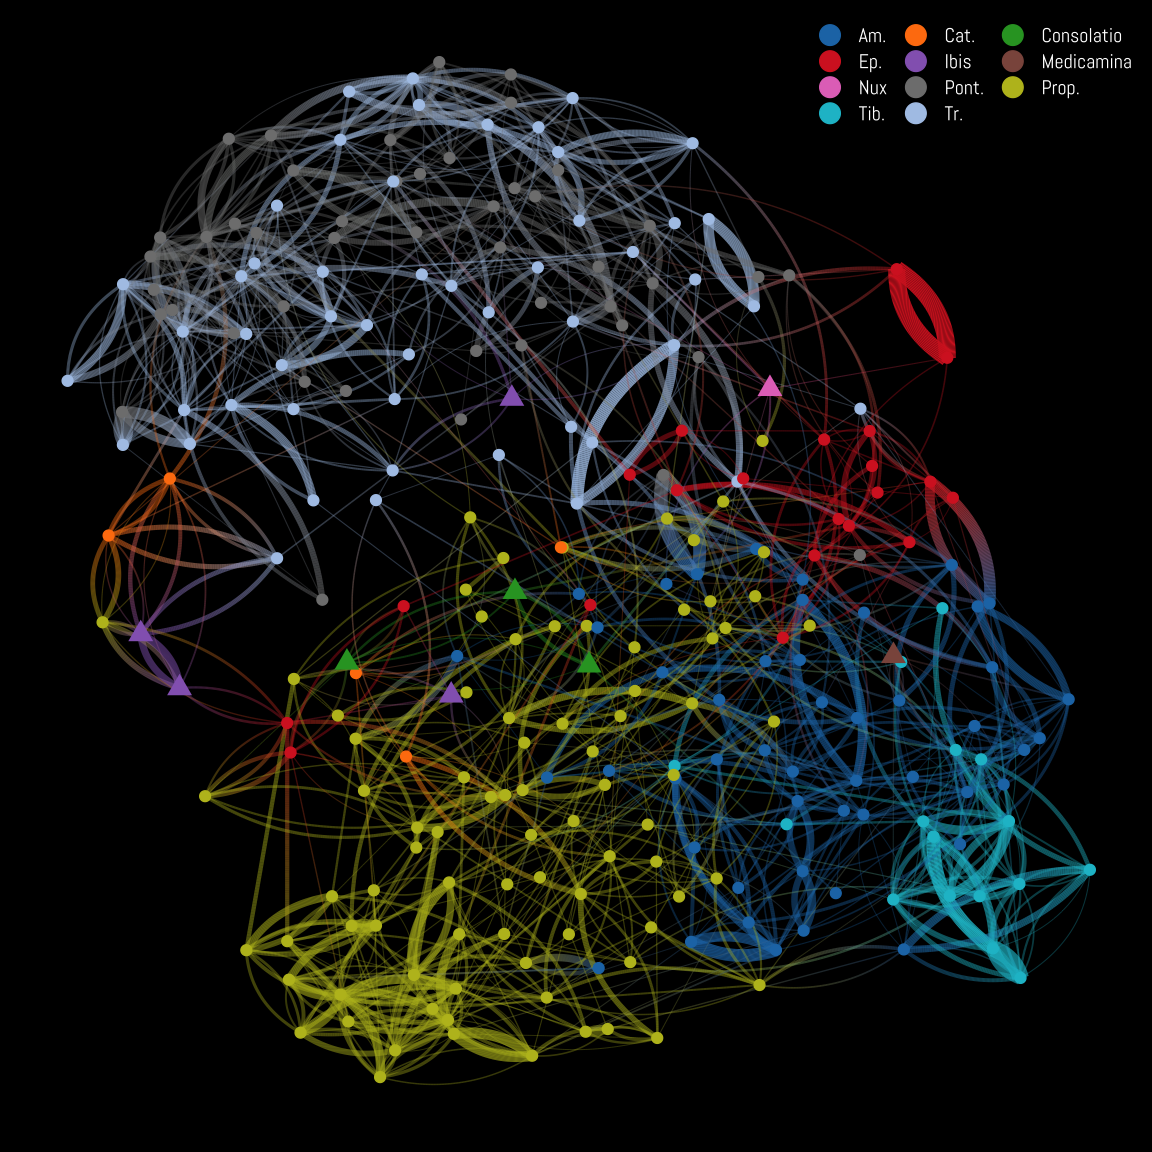

In [22]:
%%R -i graph_trim  -h 8 -w 8 -u in -r 144

# other libraries only need to be loaded once
library(ggraph)
library(tidygraph)
library(showtext)
font_add_google("Abel", "fnt")
showtext_auto()

pal <- c("#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "grey50", "#A65628")
bgcol <- 'black'

# Seed for the layout
set.seed(42)
gr1 <- as_tbl_graph(graph_trim)
# Plot
gr1 %>%
    # Add a node attribute called 'work' which is the poem name with
    # no numbers eg Pont. 3 4 -> Pont.
    activate(nodes) %>%
    mutate(work = str_replace_all(name, '\\s[0-9]+', '')) %>%
    # Layout with Fruchtermann Reingold
    ggraph(layout = 'fr') + 
    # fan2 does curved lines when nodes are linked in both directions
    # and also lets you interpolate colour along the edge
    geom_edge_fan2(
        aes(
            # Aesthetically filter out noisy minor edges.
            # This magic param is determined by experimentation
            # and depends on the number of samples etc.
            # Slightly hacky, but doesn't affect graph layout,
            # just makes the visualisation cleaner.
            filter=weight>=120,
            width=weight,
            color=node.work,
            alpha=weight
        ),
        strength=2,
        show.legend=FALSE
    ) +
    # Normal nodes
    geom_node_point(size = 2.2, aes(color = work), alpha=1) +
    # Special nodes
    geom_node_point(
        aes(
            filter=work %in% c('Nux','Ibis','Consolatio','Medicamina'),
            color=work
        ),
        size=4,
        shape=17,
        show.legend=FALSE
    ) +

    
    scale_fill_paletteer_d('ggsci::category20_d3') +
    scale_colour_paletteer_d('ggsci::category20_d3') +
    scale_edge_color_manual(values=pal_d3("category20")(20)) +
    scale_edge_width(range=c(0.2,4)) +
    scale_edge_alpha(range=c(0.3,1)) +
    
    guides(color=guide_legend(ncol=3,byrow=TRUE, override.aes = aes(size=4.5))) +

    theme_minimal() +
    theme(
        #plot.title = element_text(margin = margin(b = 50)),
        panel.border = element_blank(),
        panel.background = element_rect(fill = bgcol,color=bgcol),
        plot.background = element_rect(fill = bgcol,color=bgcol),
        legend.title=element_blank(),
        legend.position=c(0.85,0.94),
        #legend.position= 'None',
        legend.text=element_text(size=10,color='white'),
        legend.spacing.x = unit(2, 'mm'),
        legend.spacing.y = unit(-1.5, 'mm'),
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        text = element_text(family="fnt"),
        panel.grid.minor=element_blank(), 
        panel.grid.major=element_blank()
    )

# fn <- "ele_ngrams_bct_black.pdf"
# ggsave(fn, dpi=600, width=8, height=6, device=cairo_pdf)


In [23]:
lsa_data.shape

(279, 50)

In [24]:
test_corpus = pd.concat(
    [corpus[corpus.Author != "ps-Ovid"], non_elegy_vecs]
).reset_index(drop=True)
test_corpus

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
465,V.Flaccus,195-Argonautica,195-Argonautica,81,personat et teneris summittit gramina plantis\...
466,Lucretius,196-DRN,196-DRN,96,kum konwenerunt i_bad altos denikwe montis\nko...
467,Horace,197-Hor.,197-Hor. Sat.,61,aestates peraget kwi nigris prandia moris\nfin...
468,Vergil,198-Aeneid,198-Aeneid,91,sik memorat simul aenean in regia dukit\ntekta...


In [25]:
lenc = LabelEncoder()
labels = lenc.fit_transform(test_corpus.Author)
labels

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  0,  0,
        0,  0,  0,  5,  5

In [26]:
len(labels)

470

In [27]:
from ruzicka.Order2Verifier import Order2Verifier

verifier = Order2Verifier(
    metric="nini", base="instance", nb_bootstrap_iter=500, rnd_prop=0.35
)

In [28]:
from ruzicka.score_shifting import ScoreShifter
from ruzicka.evaluation import pan_metrics
from sklearn.preprocessing import MinMaxScaler

In [29]:
# vectorizer = make_pipeline(
#     TfidfVectorizer(
#         sublinear_tf=True, use_idf=False, norm="l2", analyzer="char", ngram_range=(2, 4)
#     ),
#     StandardScaler(with_mean=False),
#     Normalizer(),
#     TruncatedSVD(50, random_state=42),
#     MinMaxScaler(),
# )

vectorizer = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(5, 5),
        max_features=10000,
    ),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    # StandardScaler(),
    # TruncatedSVD(50, random_state=42),
    # Normalizer(),
    # MinMaxScaler(),
)

In [30]:
def make_up_lies(X, y):
    lies_labels = []
    n_labels = max(y) + 1
    for lab in y:
        while True:
            r = np.random.randint(n_labels)
            if r != lab:
                lies_labels.append(r)
                break
    ret_X = np.concatenate([X, X.copy()])
    ret_y = np.concatenate([y, lies_labels])
    ret_gt = np.concatenate([[1.0] * len(X), [0.0] * len(X)])
    return (ret_X, ret_y, ret_gt)

In [31]:
X = test_corpus.Chunk
X

0      hank tua penelope lento tibi mittit ulikse\nni...
1      hospita demopoon tua te rodopeia pyllis\nultra...
2      kwam legis a rapta briseide littera wenit\nwik...
3      kwam nisi tu dederis karitura_st ipsa salutem\...
4      perlegis an konjunks prohibet nowa perlege non...
                             ...                        
465    personat et teneris summittit gramina plantis\...
466    kum konwenerunt i_bad altos denikwe montis\nko...
467    aestates peraget kwi nigris prandia moris\nfin...
468    sik memorat simul aenean in regia dukit\ntekta...
469    in bu_ret kurwi for_makkipit ulmus aratri\nhui...
Name: Chunk, Length: 470, dtype: object

In [32]:
vectorizer.fit_transform(X).shape

(470, 10000)

In [33]:
logger = logging.getLogger("ruzicka")

In [34]:
for handler in logger.handlers:
    handler.setLevel(logging.INFO)

In [35]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

In [36]:
import pkg_resources

pkg_resources.require("ruzicka")[0].version

'0.0.5'

In [37]:
np.unique(y)

array(['Am. 1 1', 'Am. 1 10', 'Am. 1 11', 'Am. 1 12', 'Am. 1 13',
       'Am. 1 14', 'Am. 1 15', 'Am. 1 2', 'Am. 1 3', 'Am. 1 4', 'Am. 1 5',
       'Am. 1 6', 'Am. 1 7', 'Am. 1 8', 'Am. 1 9', 'Am. 2 1', 'Am. 2 10',
       'Am. 2 11', 'Am. 2 12', 'Am. 2 13', 'Am. 2 14', 'Am. 2 15',
       'Am. 2 16', 'Am. 2 17', 'Am. 2 18', 'Am. 2 19', 'Am. 2 2',
       'Am. 2 4', 'Am. 2 5', 'Am. 2 6', 'Am. 2 7', 'Am. 2 8', 'Am. 2 9',
       'Am. 3 1', 'Am. 3 10', 'Am. 3 11', 'Am. 3 12', 'Am. 3 13',
       'Am. 3 14', 'Am. 3 15', 'Am. 3 2', 'Am. 3 3', 'Am. 3 4', 'Am. 3 5',
       'Am. 3 6', 'Am. 3 7', 'Am. 3 8', 'Am. 3 9', 'Cat. 65', 'Cat. 66',
       'Cat. 67', 'Cat. 68', 'Cat. 76', 'Consolatio 1', 'Consolatio 2',
       'Consolatio 3', 'Ep. 1', 'Ep. 10', 'Ep. 11', 'Ep. 12', 'Ep. 13',
       'Ep. 14', 'Ep. 15', 'Ep. 16', 'Ep. 17', 'Ep. 18', 'Ep. 19',
       'Ep. 2', 'Ep. 20', 'Ep. 21', 'Ep. 3', 'Ep. 4', 'Ep. 5', 'Ep. 6',
       'Ep. 7', 'Ep. 8', 'Ep. 9', 'Ibis 1', 'Ibis 2', 'Ibis 3', 'Ibis 4',
       '

In [38]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
shifter = ScoreShifter(min_spread=0.2)
verifier = Order2Verifier(
    metric="nini", base="instance", rank=True, nb_bootstrap_iter=500, rnd_prop=0.35
)
X = test_corpus.Chunk
y = labels
for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
    logger.info(
        f"Training on {len(train_index)} training documents with {len(np.unique(y))} labels"
    )
    train_X = vectorizer.fit_transform(X[train_index], y[train_index])
    verifier.fit(train_X, y[train_index])
    test_X_raw = vectorizer.transform(X[test_index])
    test_X, test_y, test_gt = make_up_lies(test_X_raw, y[test_index])
    test_scores = verifier.predict_proba(test_X, test_y, nb_imposters=30)
    shifter = ScoreShifter()
    logger.info(f"Fitting score shifter...")
    shifter.fit(predicted_scores=test_scores, ground_truth_scores=test_gt)
    logger.info(f"Transforming {len(test_scores)} test scores...")
    test_scores = shifter.transform(test_scores)
    dev_acc_score, dev_auc_score, dev_c_at_1_score = pan_metrics(
        prediction_scores=test_scores, ground_truth_scores=test_gt
    )
    logger.info(f"Accuracy:  {dev_acc_score}")
    logger.info(f"AUC:  {dev_auc_score}")
    logger.info(f"c@1:  {dev_c_at_1_score}")
    logger.info(f"AUC x c@1:  {dev_auc_score * dev_c_at_1_score}")

08/07/2023 03:41:51 [ruzicka:INFO] Training on 423 training documents with 12 labels


08/07/2023 03:41:58 [ruzicka:INFO] # test documents processed: 10 out of 94
08/07/2023 03:42:04 [ruzicka:INFO] # test documents processed: 20 out of 94
08/07/2023 03:42:12 [ruzicka:INFO] # test documents processed: 30 out of 94
08/07/2023 03:42:17 [ruzicka:INFO] # test documents processed: 40 out of 94
08/07/2023 03:42:24 [ruzicka:INFO] # test documents processed: 50 out of 94
08/07/2023 03:42:28 [ruzicka:INFO] # test documents processed: 60 out of 94
08/07/2023 03:42:32 [ruzicka:INFO] # test documents processed: 70 out of 94
08/07/2023 03:42:35 [ruzicka:INFO] # test documents processed: 80 out of 94
08/07/2023 03:42:39 [ruzicka:INFO] # test documents processed: 90 out of 94
08/07/2023 03:42:40 [ruzicka:INFO] Fitting score shifter...
08/07/2023 03:42:44 [ruzicka:INFO] p1 for optimal combo: 0.686
08/07/2023 03:42:44 [ruzicka:INFO] p2 for optimal combo: 0.716
08/07/2023 03:42:44 [ruzicka:INFO] AUC for optimal combo: 0.9981892258940697
08/07/2023 03:42:44 [ruzicka:INFO] c@1 for optimal co

In [39]:
def benchmark_imposters(X, y, splitter, vectorizer, verifier, shifter):
    accs = []
    c_at_1s = []
    for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
        logger.info(f"Training on {len(train_index)} training documents")
        train_X = vectorizer.fit_transform(X[train_index], y[train_index])
        verifier.fit(train_X, y[train_index])
        test_X_raw = vectorizer.transform(X[test_index])
        test_X, test_y, test_gt = make_up_lies(test_X_raw, y[test_index])
        test_scores = verifier.predict_proba(test_X, test_y, nb_imposters=30)
        if not shifter:
            shifter = ScoreShifter(min_spread=0.2)
            logger.info(f"Fitting score shifter...")
            shifter.fit(predicted_scores=test_scores, ground_truth_scores=test_gt)
        logger.info(f"Transforming {len(test_scores)} test scores...")
        test_scores = shifter.transform(test_scores)
        dev_acc_score, dev_auc_score, dev_c_at_1_score = pan_metrics(
            prediction_scores=test_scores, ground_truth_scores=test_gt
        )
        logger.info(f"Accuracy:  {dev_acc_score}")
        logger.info(f"AUC:  {dev_auc_score}")
        logger.info(f"c@1:  {dev_c_at_1_score}")
        logger.info(f"AUC x c@1:  {dev_auc_score * dev_c_at_1_score}")
        accs.append(dev_acc_score)
        c_at_1s.append(dev_c_at_1_score)
    return (accs, c_at_1s)

In [40]:
aa, cc = benchmark_imposters(
    test_corpus.Chunk, labels, sss, vectorizer, verifier, shifter
)
print(sp.stats.describe(aa))
print(sp.stats.describe(cc))

08/07/2023 03:42:44 [ruzicka:INFO] Training on 423 training documents


08/07/2023 03:42:50 [ruzicka:INFO] # test documents processed: 10 out of 94
08/07/2023 03:42:57 [ruzicka:INFO] # test documents processed: 20 out of 94
08/07/2023 03:43:04 [ruzicka:INFO] # test documents processed: 30 out of 94
08/07/2023 03:43:09 [ruzicka:INFO] # test documents processed: 40 out of 94
08/07/2023 03:43:14 [ruzicka:INFO] # test documents processed: 50 out of 94
08/07/2023 03:43:18 [ruzicka:INFO] # test documents processed: 60 out of 94
08/07/2023 03:43:22 [ruzicka:INFO] # test documents processed: 70 out of 94
08/07/2023 03:43:25 [ruzicka:INFO] # test documents processed: 80 out of 94
08/07/2023 03:43:29 [ruzicka:INFO] # test documents processed: 90 out of 94
08/07/2023 03:43:31 [ruzicka:INFO] Transforming 94 test scores...
08/07/2023 03:43:31 [ruzicka:INFO] Accuracy:  0.9468085106382979
08/07/2023 03:43:31 [ruzicka:INFO] AUC:  0.9995473064735174
08/07/2023 03:43:31 [ruzicka:INFO] c@1:  0.9669533725667723
08/07/2023 03:43:31 [ruzicka:INFO] AUC x c@1:  0.9665156390346008

DescribeResult(nobs=10, minmax=(0.8936170212765957, 0.9468085106382979), mean=0.9276595744680851, variance=0.0002716161158895431, skewness=-0.7257747386024279, kurtosis=-0.18724279835390645)
DescribeResult(nobs=10, minmax=(0.9031235853327297, 0.9669533725667723), mean=0.9423494794024446, variance=0.00043124460617632805, skewness=-0.4067535482201341, kurtosis=-0.6836380469401844)


In [41]:
ngrams_std = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l2",
        analyzer="char",
        ngram_range=(2, 4),
        max_features=5000,
    ),
    StandardScaler(with_mean=False),
    FunctionTransformer(lambda x: x.todense(), accept_sparse=True),
    # TruncatedSVD(20, random_state=42),
    Normalizer(),
)

In [42]:
aa, cc = benchmark_imposters(
    test_corpus.Chunk, labels, sss, ngrams_std, verifier, shifter
)
print(sp.stats.describe(aa))
print(sp.stats.describe(cc))

08/07/2023 03:50:40 [ruzicka:INFO] Training on 423 training documents
08/07/2023 03:50:44 [ruzicka:INFO] # test documents processed: 10 out of 94
08/07/2023 03:50:47 [ruzicka:INFO] # test documents processed: 20 out of 94
08/07/2023 03:50:51 [ruzicka:INFO] # test documents processed: 30 out of 94
08/07/2023 03:50:54 [ruzicka:INFO] # test documents processed: 40 out of 94
08/07/2023 03:50:57 [ruzicka:INFO] # test documents processed: 50 out of 94
08/07/2023 03:50:59 [ruzicka:INFO] # test documents processed: 60 out of 94
08/07/2023 03:51:02 [ruzicka:INFO] # test documents processed: 70 out of 94
08/07/2023 03:51:04 [ruzicka:INFO] # test documents processed: 80 out of 94
08/07/2023 03:51:07 [ruzicka:INFO] # test documents processed: 90 out of 94
08/07/2023 03:51:08 [ruzicka:INFO] Transforming 94 test scores...
08/07/2023 03:51:08 [ruzicka:INFO] Accuracy:  0.925531914893617
08/07/2023 03:51:08 [ruzicka:INFO] AUC:  0.9950203712086917
08/07/2023 03:51:08 [ruzicka:INFO] c@1:  0.9255319148936

DescribeResult(nobs=10, minmax=(0.8829787234042553, 0.9361702127659575), mean=0.9170212765957448, variance=0.0002716161158895425, skewness=-0.7257747386024538, kurtosis=-0.18724279835387359)
DescribeResult(nobs=10, minmax=(0.9148936170212766, 0.946129470348574), mean=0.9273992756903574, variance=8.53233427440122e-05, skewness=0.7423540401258779, kurtosis=-0.22444426820789998)


In [43]:
real_verifier = Order2Verifier(
    metric="nini", base="instance", nb_bootstrap_iter=1000, rnd_prop=0.35
)

In [44]:
real_verifier.fit(vectorizer.fit_transform(test_corpus.Chunk), labels)

In [45]:
problems = corpus[corpus.Author == "ps-Ovid"]
problems

,Author,Work,Poem,LEN,Chunk
278,ps-Ovid,Nux,Nux,182,nuks ego junkta wiae kum sim sine krimine wita...
279,ps-Ovid,Medicamina,Medicamina,100,diskite kwae fakiem kommendet kura puellae\net...
280,ps-Ovid,Consolatio,Consolatio 1,158,wisa diu feliks mater modo dikta neronum\njam ...
281,ps-Ovid,Consolatio,Consolatio 2,158,at_kwutinam drusi manus alte_ret altera fratri...
282,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
283,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
284,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
285,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...
286,ps-Ovid,Ibis,Ibis 4,178,aut te dewoweat kertis abdera diebus\nsaksakwe...


In [46]:
shifter.transform(
    real_verifier.predict_proba(
        vectorizer.transform(problems.Chunk),
        lenc.transform(["Ovid"] * len(problems)),
        nb_imposters=30,
    )
)

[0.968197662791219,
 0.716,
 0.9999872841514559,
 0.8919025715266478,
 0.9554818142471244,
 0.9809135113353149,
 0.9364080414309806,
 0.9427659657030285,
 0.8919025715266492]

In [51]:
real_verifier.predict_proba(
    vectorizer.transform(problems.Chunk),
    lenc.transform(["Ovid"] * len(problems)),
    nb_imposters=30,
)

array([1.        , 0.97566667, 1.        , 0.992     , 0.9975    ,
       0.9995    , 0.9995    , 0.99633333, 0.993     ])

In [48]:
test_corpus.Author.unique()

array(['Ovid', 'Tibullus', 'Propertius', 'Catullus', 'Vergil', 'Juvenal',
       'Silius', 'Statius', 'Lucan', 'V.Flaccus', 'Lucretius', 'Horace'],
      dtype=object)